## Summary of notebook:

This notebook builts the Locality-Sensitive Hashing Weighted K-Nearest Neighbour (LSH-WKNN) algorithm to perform localisation. After the model was built, the model's effectiveness was then tested out on different datasets with optimal/non-optimal hyperparameters.

Overview of the LSH-WKNN algorithm:

<u>1. Offline Phase<u>
- Dimension Reduction of fingerprint images (Reduce by taking average of each feature)
- K-Means Clustering (Cluster the fingerprint images)
- Generate hash table for each cluster (Utilise LSH algorithm to generate)
- Generate processed fingerprint database

<u>2. Online Phase<u>
- Cluster prediction (Predict cluster using K-Means model)
- Look up hash table (Calculate hash value and look up hash table)
- Generate regression output by taking a weighted average of K Nearest Neighbours

Datasets used in this notebook are:

Trial 1: Augmented open-source dataset using Gaussian noise - [Link](#wknn_gaussian) <br>
Files: augmented_features_10_ue1_v2_ds.npy, augmented_labels_10_ue1_v2_ds.npy

Trial 2: Augmented open-source dataset using Barrel Rolling - [Link](#wknn_br) <br>
Files: augmented_features_8_ue1_br_ds.npy, augmented_labels_8_ue1_br_ds.npy

Trial 3: Raw NTU's MISO SNR40 dataset, 100 samples per RP - [Link](#wknn_raw_100samples_miso_snr40) <br>
Files:  miso_snr40_raw_labels.csv, miso_snr40_raw_labels.npy, miso_snr40_raw_features.npy

Trial 4: Raw NTU's MISO SNR40 dataset, 1 sample per RP - [Link](#wknn_raw_1sample_miso_snr40) <br>
Files: miso_snr40_raw_labels.csv, miso_snr40_raw_labels.npy, miso_snr40_raw_features.npy

Trial 5: Augmented NTU's MISO SNR40 dataset - [Link](#wknn_augmented_miso_snr40) <br>
Files: miso_snr40_augmented_labels.csv, miso_snr40_augmented_labels.npy, miso_snr40_augmented_features.npy

In [1]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


## <a id='wknn_gaussian'>Trial 1: Augmented open-source dataset using Gaussian noise</a>

In [2]:
# Extract dataset
import os 

print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/wknn
/home/jovyan/committed_git/datasets


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

# Import dataset
features = np.load('augmented_features_10_ue1_v2_ds.npy')
labels = np.load('augmented_labels_10_ue1_v2_ds.npy')

print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

X = features
y = labels

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Shape of features np array: (89628, 193, 16)
Shape of labels np array: (89628,)


### Offline Phase:

#### Dimension Reduction

In [4]:
# As data across different samples are taken at different time intervals, makes
# sense to average the value out
# Reduce each feature from shape of (193, 16) --> (1, 16)

# Preprocess X_train and X_test => Reduce dimensions by averaging
reduced_X_train = []
reduced_X_test = []

for feature in X_train:  
    reduced_X_train.append(np.mean(feature, axis = 0))
for feature in X_test:
    reduced_X_test.append(np.mean(feature, axis = 0))
    
X_train = np.array(reduced_X_train)
X_test = np.array(reduced_X_test)

print(X_train.shape)
print(X_test.shape)

(71702, 16)
(17926, 16)


#### K-Means clustering

In [5]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [8]:
inertias, distortions = [], []
inertias_mapping, distortions_mapping = {}, {}
K = range(1, 20)

for k in K:
    
    # Build and fit the model
    kmeanModel = KMeans(n_clusters = k).fit(X_train)
    kmeanModel.fit(X_train)
    
    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_train.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    inertias_mapping[k] = sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_train.shape[0]
    distortions_mapping[k] = kmeanModel.inertia_

#### Metrics used:

- Distortion: Average of the squared distances from the cluster centers of the respective clusters to each data point (Euclidean distance metric)

- Inertia: Average sum of squared distances of samples to their closest cluster centre

In [180]:
for key,val in inertias_mapping.items():
    print(f'No. of clusters: {key}, inertias: {val}')

No. of clusters: 1, inertias: 0.5363316960429995
No. of clusters: 2, inertias: 0.4750941792684408
No. of clusters: 3, inertias: 0.431973008199725
No. of clusters: 4, inertias: 0.3997290023811501
No. of clusters: 5, inertias: 0.36183796465559603
No. of clusters: 6, inertias: 0.3323592064411866
No. of clusters: 7, inertias: 0.319621414276987
No. of clusters: 8, inertias: 0.3074309831664756
No. of clusters: 9, inertias: 0.29658059947807663
No. of clusters: 10, inertias: 0.2888429038733291
No. of clusters: 11, inertias: 0.28129038602301154
No. of clusters: 12, inertias: 0.2748599303863045
No. of clusters: 13, inertias: 0.2689964138889303
No. of clusters: 14, inertias: 0.2647799845824608
No. of clusters: 15, inertias: 0.2598982673424333
No. of clusters: 16, inertias: 0.25653214643578404
No. of clusters: 17, inertias: 0.2519857851262393
No. of clusters: 18, inertias: 0.24874113142911874
No. of clusters: 19, inertias: 0.24562293141799563


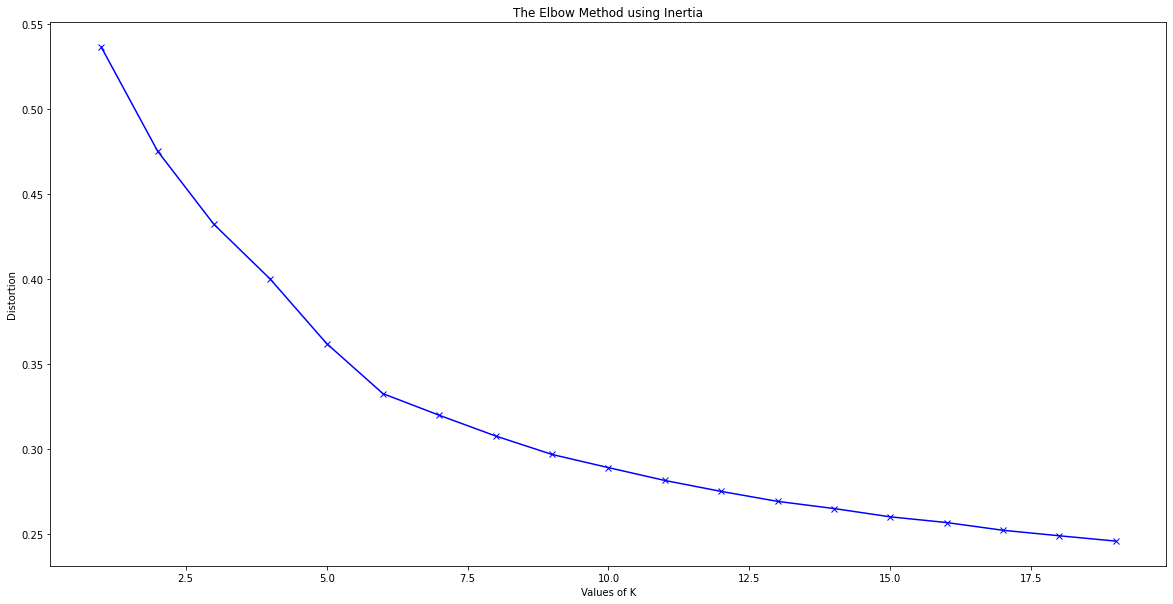

In [181]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Inertia')
plt.show()

In [182]:
for key,val in distortions_mapping.items():
    print(f'No. of clusters: {key}, distortion: {val}')

No. of clusters: 1, distortion: 21841.907168491467
No. of clusters: 2, distortion: 17415.012126380363
No. of clusters: 3, distortion: 14425.495470297068
No. of clusters: 4, distortion: 12189.391213838757
No. of clusters: 5, distortion: 10137.244002683117
No. of clusters: 6, distortion: 8621.437757923864
No. of clusters: 7, distortion: 7960.194419675813
No. of clusters: 8, distortion: 7353.421935603191
No. of clusters: 9, distortion: 6801.638848209186
No. of clusters: 10, distortion: 6446.499240625197
No. of clusters: 11, distortion: 6101.452523155159
No. of clusters: 12, distortion: 5824.011766266433
No. of clusters: 13, distortion: 5603.30090779632
No. of clusters: 14, distortion: 5396.198959389618
No. of clusters: 15, distortion: 5225.016058255846
No. of clusters: 16, distortion: 5075.420523312527
No. of clusters: 17, distortion: 4914.13716677106
No. of clusters: 18, distortion: 4794.883652791822
No. of clusters: 19, distortion: 4670.469500248675


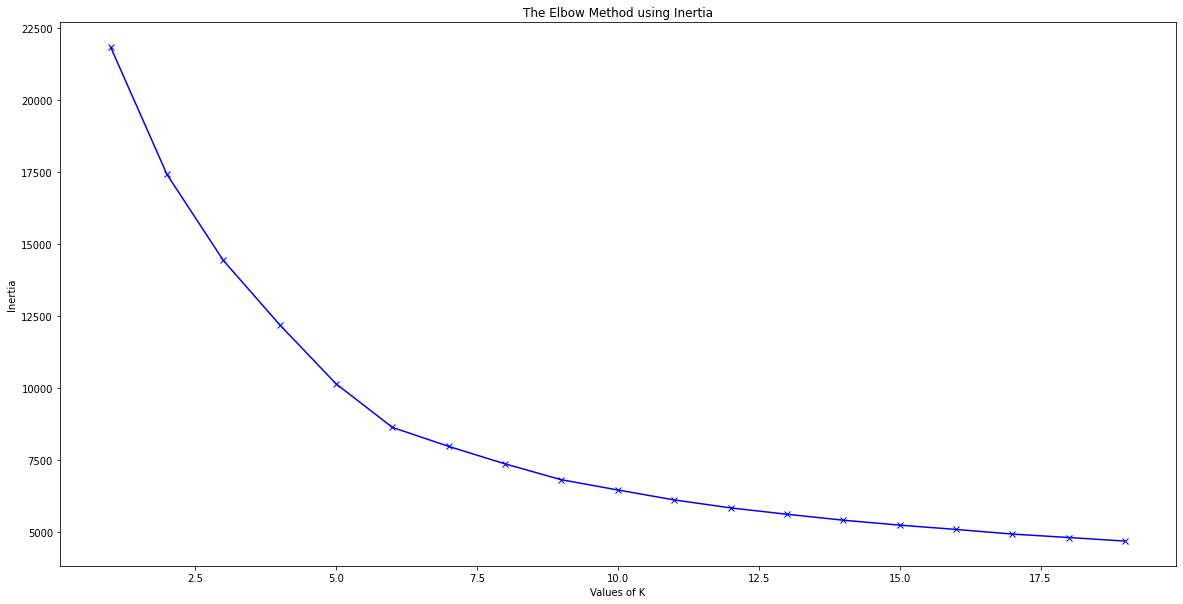

In [183]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Optimal no. of clusters = 6

#### Generate processed fingerprint database

In [6]:
import h5py
# Get dictionary of RP index and coordinates
# Open HDF5 file and access the dataset
filename = 'dataset_SNR10_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

# Close the HDF5 file
hdf5_file.close()

In [7]:
# Perform clustering using optimal number of clusters
kmeans_model = KMeans(n_clusters = 6).fit(X_train)

# Get the correct cluster for each of the RP
label_arr = kmeans_model.labels_
print(f'No. of unique clusters: {np.unique(label_arr)}')
print(f'No. of fp clustered: {len(label_arr)}')

# Create a database containing key-value of location vector, cluster no. and fingerprint
processed_fp_db = []
for i in range(len(X_train)):
    
    processed_fp = {}
    processed_fp['coords_idx'] = y_train[i]
    processed_fp['cluster_no'] = label_arr[i]
    processed_fp['fp'] = X_train[i]
    processed_fp_db.append(processed_fp)

print(len(processed_fp_db), processed_fp_db[0])

No. of unique clusters: [0 1 2 3 4 5]
No. of fp clustered: 71702
71702 {'coords_idx': 383, 'cluster_no': 2, 'fp': array([0.64390807, 0.26444111, 0.56497193, 0.58222285, 0.66000711,
       0.29986503, 0.52431564, 0.61377072, 0.66395987, 0.35654856,
       0.47202562, 0.64252936, 0.65919535, 0.41383729, 0.42154467,
       0.65629   ])}


#### Apply LSH algorithm for each of the clusters to hash fingerprints generated  and save the hash values in a data structure.

- Components of LSH algorithm
    - Stable distribution: Gaussian normal distribution with mean = 0 and variance = 1
    - dimension, d: Dimensions of the fingerprints with reduced dimensions, with shape of (1,16)
    - alpha, a: Vector of dimension d whose entry are chosen independently from the p-stable distribution.
    - vector v: Vector of dimension d that represents our fingerprint
    - r: Length of segment, by 'chopping' real line into eqi-distance segment of length r
    - b: A random number in the range of (0,r)

### Data Visualisation

In [8]:
alpha_vector = np.random.standard_normal(size = (1,16))

Cluster 0
Max: 2.003132667637134, Min: 0.15052124031277891, Avg: 1.0956390629454984, IQR: 0.30361624104705087, No. of bins: 66
Cluster 1
Max: 2.0808362625938726, Min: -0.0200867407365084, Avg: 0.9954807160746074, IQR: 0.41023914514067505, No. of bins: 65
Cluster 2
Max: 2.2695310914325026, Min: 0.7972819588031415, Avg: 1.5956215990635136, IQR: 0.2932231890323982, No. of bins: 62
Cluster 3
Max: 1.9797227010402108, Min: 0.9216150115557293, Avg: 1.470346225504191, IQR: 0.34547102638413585, No. of bins: 30
Cluster 4
Max: 1.8108564647816818, Min: 0.3622312660170001, Avg: 1.1328820375383633, IQR: 0.5162519858840293, No. of bins: 28
Cluster 5
Max: 2.6536010952978564, Min: 0.602040236276117, Avg: 1.6913448985880297, IQR: 0.440759520449441, No. of bins: 60


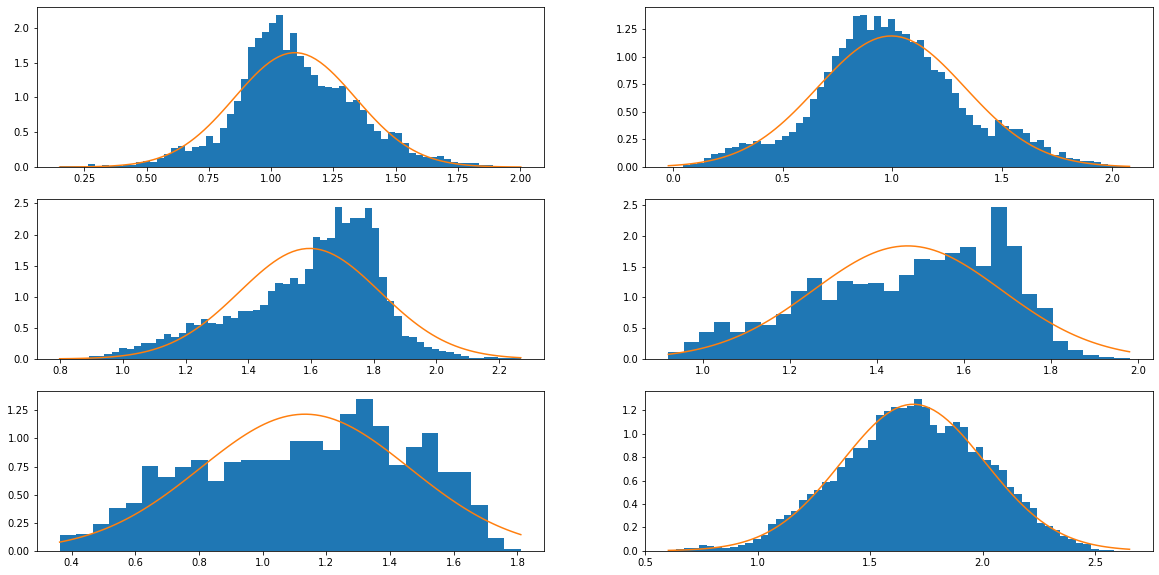

In [9]:
# Get stable distribution - Gaussian normal distribution with mean = 0 and variance = 1,
# with dimension d => (1,16)
import random
from scipy.stats import norm

# Perform dot product alpha_vector . vector v = scalar
# scalar = np.dot(alpha_vector, reduced_dims_features[0])

# For each cluster,
cluster0_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 0]
cluster1_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 1]
cluster2_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 2]
cluster3_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 3]
cluster4_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 4]
cluster5_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 5]

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(3,2)

for i in range(3):
    for j in range(i,i + 2):

        # Determine the elements from each cluster 
        print(f'Cluster {i + j}')
        cluster_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == (i + j)]
        
        # Get distribution of scalar quantities for each poimt
        num_features = len(cluster_rps)
        scalar_res = np.zeros(shape = (num_features, 1), dtype = np.float64)
    
        for k in range(num_features):
            scalar_res[k] = np.dot(alpha_vector, cluster_rps[k]['fp'])
        
        (n, bins, patches) = axs[i][j - i].hist(scalar_res, bins = 'auto', density = True)
#       print(f'Number of bins: {len(n)}, Data point count for each bin: {n}')

        max_val = np.amax(scalar_res)
        min_val = np.amin(scalar_res)
        avg_val = np.mean(scalar_res)
        q75, q25 = np.percentile(scalar_res, [75,25])
        iqr = q75 - q25
    
        print(f'Max: {max_val}, Min: {min_val}, Avg: {avg_val}, IQR: {iqr}, No. of bins: {len(n)}')
        x = np.linspace(min_val, max_val, 100)
        axs[i][j - i].plot(x, norm.pdf(x, np.mean(scalar_res), np.std(scalar_res)))

In [10]:
# Generation of hash function
# Let length r be (cluster max - cluster min) / 100
# Stick to 100 hash values for now to make sure data points are evenly spread out, but not too little
# points per hash value
import math

def get_minmax(cluster_rps):
    
    num_features = len(cluster_rps)
    scalar_res = np.zeros(shape = (num_features, 1), dtype = np.float64)
    
    for k in range(num_features):
        scalar_res[k] = np.dot(alpha_vector, cluster_rps[k]['fp'])
    
    return (np.amax(scalar_res), np.amin(scalar_res))

def get_hash_values(cluster_rps):
    
    max_val, min_val = get_minmax(cluster_rps)
    
    # Declare parameters of hash function
    num_segments = 3
    r = (max_val - min_val) / num_segments
    b = random.uniform(0, r)
    
    # print(r,b)
    
    # Make hash table
    hash_table = {}
    
    # Generate hash values for each of the RP
    for rp in cluster_rps:
        
        hash_value = math.floor((np.dot(alpha_vector, rp['fp']) + b) / r)
        cur_vals = hash_table.get(hash_value, [])
        cur_vals.append(rp['coords_idx'])
        hash_table[hash_value] = cur_vals
        
    return r, b, hash_table

Cluster 0
r: 0.6175371424414516, b: 0.13896036305966133
Cluster 1
r: 0.7003076677767938, b: 0.12479820455413494
Cluster 2
r: 0.49074971087645375, b: 0.24505364869922838
Cluster 3
r: 0.3527025631614938, b: 0.21301295538760262
Cluster 4
r: 0.4828750662548939, b: 0.29435236244753515
Cluster 5
r: 0.6838536196739131, b: 0.137611643381647


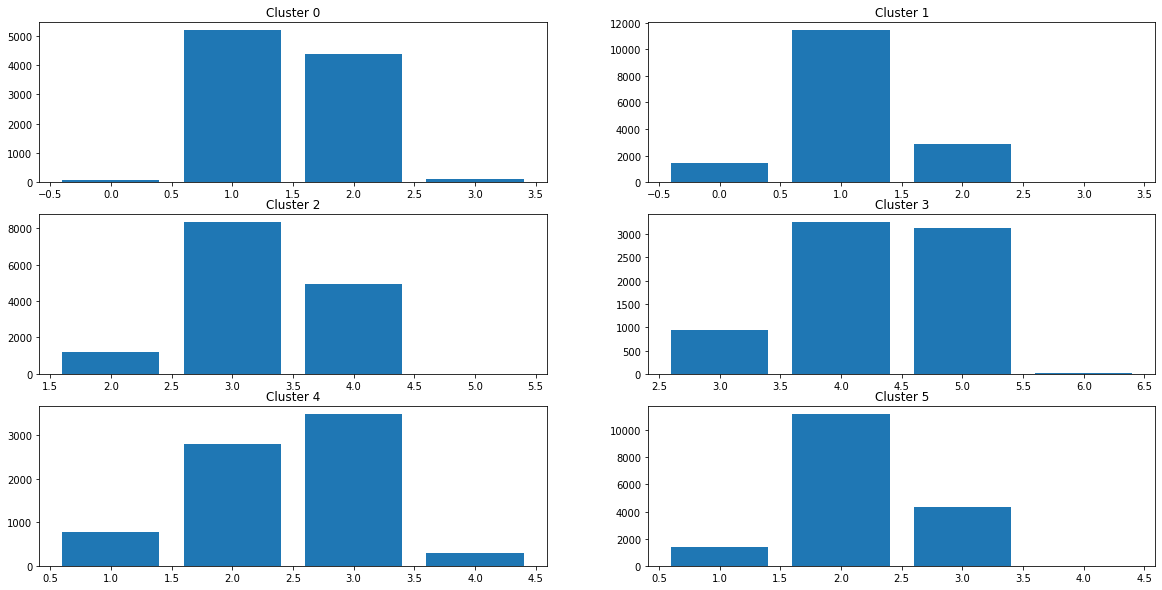

In [11]:
# For each cluster, visualise the spread of hashed values using a histogram
plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(3,2)

for i in range(3):
    for j in range(i,i + 2):

        # Determine the elements from each cluster 
        print(f'Cluster {i + j}')
        cluster_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == (i + j)]
        
        # Get hash values for each cluster
        r, b, hash_vals = get_hash_values(cluster_rps)
        print(f'r: {r}, b: {b}')
        
        keys = []
        num_vals = []
        
        for key, values in hash_vals.items():
            keys.append(key)
            num_vals.append(len(values))
            
        axs[i][j - i].bar(x = keys, height = num_vals)
        axs[i][j - i].title.set_text(f'Cluster {i + j}')

In [12]:
# Get hash values for each cluster 
r0, b0, cluster0_hashvals = get_hash_values(cluster0_rps)
r1, b1, cluster1_hashvals = get_hash_values(cluster1_rps)
r2, b2, cluster2_hashvals = get_hash_values(cluster2_rps)
r3, b3, cluster3_hashvals = get_hash_values(cluster3_rps)
r4, b4, cluster4_hashvals = get_hash_values(cluster4_rps)
r5, b5, cluster5_hashvals = get_hash_values(cluster5_rps)

In [13]:
# Save details of each hash function into a dictionary
clustered_rps = [cluster0_rps, cluster1_rps, cluster2_rps, cluster3_rps, cluster4_rps, cluster5_rps]
clustered_rps = enumerate(clustered_rps)
hash_dict = {}

for index, cluster in clustered_rps:
    r, b, hash_vals = get_hash_values(cluster)
    hash_dict[index] = {'r': r, 'b': b, 'hashs': hash_vals}

### Online Phase:

1. Take fingerprint at unknown location.
2. Determine appropriate cluster for that fingerprint.
3. Apply LSH algorithm to selected clustering and get top candidate RP for localisation (Apply hash function to unknown fingerprint and get top candidate RPs with the same hash values).
4. Use Euclidean Distance criterion to calculate distance between each pair of points.
5. Exploit WKNN algorithm to choose first K RPs with the smallest Dis to estimate final positioning.

In [15]:
# Function to calculate Euclidean distance
def get_ed(actual_rp, candidate_rp):
    return math.dist(actual_rp, candidate_rp)

# Exploit WKNN algorithm to choose first K RPs
# Here, let k = 3, weight = 1 / get_ed(actual_rp, candidate_rp)
# candidate_rps should be given in as a key which is the key in rp_dict which maps back to the
# actual coordinates 
def wknn(actual_rp, candidate_rps, k = 3):
    
    distances = []
    
    # For every candidate point,
    for index in candidate_rps:
        
        # Calculate the distance from each candidate point
        coords = rp_dict[index]
        dist = get_ed(rp_dict[actual_rp], coords)
        
        if dist == 0:
            # Set an arbitrary large enough number
            weight = 1e7
        else:
            weight = 1 / dist
            
        distances.append((index, coords, weight, dist))
        
    # Sort the array based on dist
    sorted_distances = sorted(distances, key = lambda tup: tup[3])
            
    # Exploit WKNN to get positioning
    # Get top candidates
    top_k_candidates = sorted_distances[:k]
    
    # For checking purposes
    # for index, _ , _ in top_k_candidates:
    #    print(rp_dict[index])
    
    # Get predicted positioning using best candidates
    # Get coordinates for all candidate positions
    candidate_pos = []
    weights = []
    
    for _, candidate, weight, _ in top_k_candidates:
        candidate_pos.append(candidate)
        weights.append(weight)
    
    # Take the weighted average of top k candidate positions to predict location
    predicted_position = np.average(candidate_pos, weights = weights, axis = 0)
    
    return predicted_position

In [16]:
# Testing on one sample

# Let's try on one test point for now
# Use clustering to predict cluster of unknown fingerprint
X_test_sample = X_test[0]
y_test_sample = y_test[0]

predicted_cluster = kmeans_model.predict([X_test_sample])[0]

# Apply LSH hash function to get cluster for unknown fingerprint
r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']

# print(X_test_sample.shape)
hashed_value = math.floor((np.dot(alpha_vector, X_test_sample) + b) / r)
# print(hashed_value)
# print(hash_vals[hashed_value])

print('Predicted:')
print(wknn(y_test_sample, hash_vals[hashed_value]))
print('--')
print('Actual')
print(rp_dict[y_test_sample])

Predicted:
[23.  46.  22.2]
--
Actual
[23.  46.  22.2]


In [17]:
# This function takes in a fingerprint from an unknown location and tries to predict
# the location
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import math

def get_closesthash(y, predicted_cluster):
    
    # For each of the hash value in this cluster,
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    actual_coords = rp_dict[y]
    
    min_avgdisterror = math.inf
    min_hashval = None
    
    for hash_val in hash_vals.keys():
        
        # Get all neighbours with that hash value
        neighbours = hash_vals[hash_val]
        err_sum = 0
        
        # Find out the average distance error with neighbouring points with this hash value        
        for neighbour in neighbours:
            
            # Calculate errors
            neighbour_coords = rp_dict[neighbour]
            err = get_ed(actual_coords, neighbour_coords) 
            err_sum += err
            
            # Calculate average
            err_avg = err_sum / len(neighbours)
            
            # Update minimum
            if err_avg < min_avgdisterror:
                min_avgdisterror = err_avg
                min_hashval = hash_val
                
        # Return the cluster with the least error
        return min_hashval
    
# Note: Fingerprint is already in the reduced dimensions form
def get_pred(x, y):
    
    # Step 1: Predict what cluster is this fp from
    predicted_cluster = kmeans_model.predict([x])[0]
    
    # Step 2: Get the hash details for that predicted cluster
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    
    # Step 3: Get the hash value for that unknown fp
    hashed_value = math.floor((np.dot(alpha_vector, x) + b) / r)
 
    # Step 4: Apply wknn algorithm on the the unknown fp
    # if the derived hash value is not present in hashed values,
    if hashed_value not in hash_vals.keys():
        # Find out the average distance error from each of the other hashed
        # value in this cluster
        # Then, use wknn on points with this hash value in this cluster
        closest_hashval = get_closesthash(y, predicted_cluster)
        y_pred = wknn(y, hash_vals[closest_hashval])
        
    else: 
        y_pred = wknn(y, hash_vals[hashed_value])
    
    return y_pred

In [18]:
# Iterate through the y_test dataset and get a prediction for each of the coordinate
y_pred = []

for i in range(len(y_test)):
    
    cur_test_sample = X_test[i]
    cur_test_label = y_test[i]
    pred = get_pred(cur_test_sample, cur_test_label)
    y_pred.append(pred)

In [19]:
def get_disterr(actual, predicted):

    x_error = (actual[0] - predicted[0])**2
    y_error = (actual[1] - predicted[1])**2
    z_error = (actual[2] - predicted[2])**2
    return x_error + y_error + z_error

def get_errcdf(errors):
    # Sort the array
    sorted_data = np.sort(errors)

    # Calculate cumulative probabilities
    n = len(sorted_data)
    cumulative_probs = np.arange(1, n + 1) / n

    return (sorted_data, cumulative_probs)
    
err_sum = 0
dist_errors = []

for i in range(len(y_pred)):
    
    actual_coords = rp_dict[y_test[i]]
    err = get_disterr(actual_coords, y_pred[i])
    err_sum += err
    dist_errors.append(np.sqrt(err))

sorted_errors, cdf_vals = get_errcdf(dist_errors)

print(f'RMSE: {np.sqrt((err_sum/len(y_pred)))}')

RMSE: 0.0608750096538175


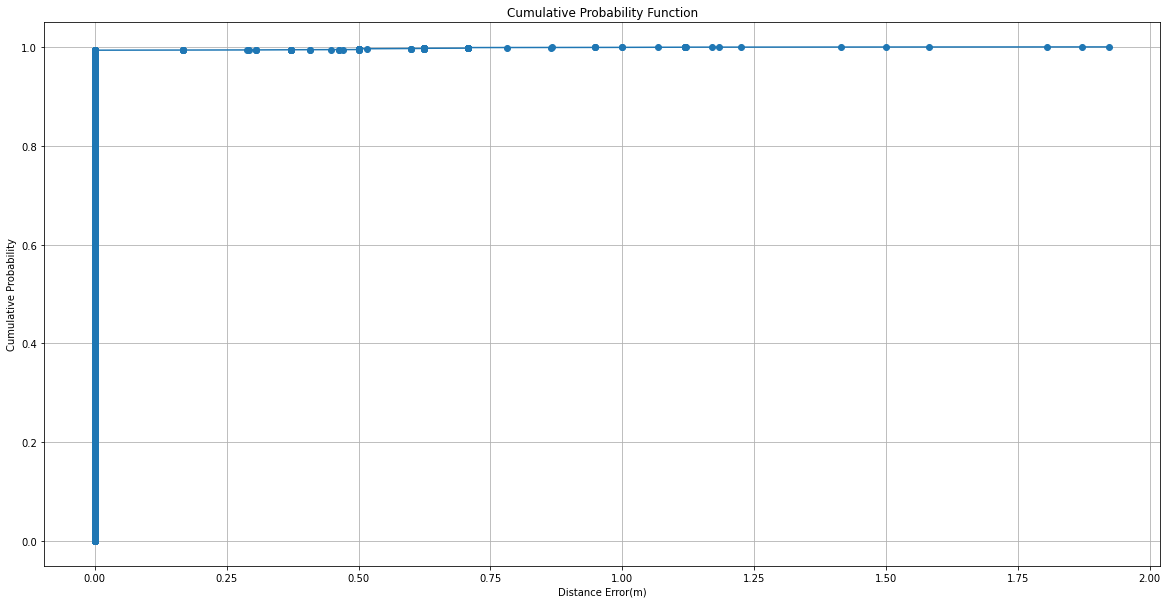

In [20]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(sorted_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()

In [21]:
# Save sorted values and cdf_values into a file
# print(sorted_errors)
# print(cdf_vals)

wknn_sorted_errors = np.array(sorted_errors)
wknn_cdf_vals = np.array(cdf_vals)

np.save('wknn_sorted_errors.npy', wknn_sorted_errors)
np.save('wknn_cdf_vals', wknn_cdf_vals)

[0.         0.         0.         ... 1.80575415 1.87082869 1.92349477]
[5.57848935e-05 1.11569787e-04 1.67354680e-04 ... 9.99888430e-01
 9.99944215e-01 1.00000000e+00]


## <a id='wknn_br'>Trial 2: Augmented open-source dataset using Barrel Rolling</a>

In [11]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib
import h5py
from sklearn.model_selection import train_test_split
import numpy as np
import os

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [12]:
# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


In [13]:
print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/datasets


In [14]:
# Get dictionary of RP index and coordinates
# Open HDF5 file and access the dataset
filename = 'dataset_SNR10_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

# Close the HDF5 file
hdf5_file.close()

In [15]:
# from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

features = np.load('augmented_features_8_ue1_br_ds.npy')
labels = np.load('augmented_labels_8_ue1_br_ds.npy')
X = features
y = labels

# random_state = 42 to always ensure same split of dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.125, random_state=42, shuffle = True)

In [34]:
print(os.getcwd())
os.chdir('../wknn')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/wknn


In [16]:
# As data across different samples are taken at different time intervals, makes
# sense to average the value out
# Reduce each feature from shape of (193, 16) --> (1, 16)

# Preprocess X_train and X_test => Reduce dimensions by averaging
reduced_X_train = []
reduced_X_test = []
reduced_X_val = []

for feature in X_train:  
    reduced_X_train.append(np.mean(feature, axis = 0))
for feature in X_test:
    reduced_X_test.append(np.mean(feature, axis = 0))
for feature in X_val:
    reduced_X_val.append(np.mean(feature, axis = 0))
        
X_train = np.array(reduced_X_train)
X_test = np.array(reduced_X_test)
X_val = np.array(reduced_X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(73255, 16)
(20931, 16)
(10466, 16)


In [17]:
# Perform clustering using optimal number of clusters
kmeans_model = KMeans(n_clusters = 6).fit(X_train)

# Get the correct cluster for each of the RP
label_arr = kmeans_model.labels_
print(f'No. of unique clusters: {np.unique(label_arr)}')
print(f'No. of fp clustered: {len(label_arr)}')

# Create a database containing key-value of location vector, cluster no. and fingerprint
processed_fp_db = []
for i in range(len(X_train)):
    
    processed_fp = {}
    processed_fp['coords_idx'] = y_train[i]
    processed_fp['cluster_no'] = label_arr[i]
    processed_fp['fp'] = X_train[i]
    processed_fp_db.append(processed_fp)

print(len(processed_fp_db), processed_fp_db[0])

No. of unique clusters: [0 1 2 3 4 5]
No. of fp clustered: 73255
73255 {'coords_idx': 3428, 'cluster_no': 1, 'fp': array([0.42753515, 0.58585465, 0.59680975, 0.54486201, 0.34364687,
       0.42548206, 0.56378531, 0.66340429, 0.2912068 , 0.42050308,
       0.56391392, 0.58025323, 0.35012222, 0.32711443, 0.41182492,
       0.56788063])}


In [23]:
# Generation of hash function
# Let length r be (cluster max - cluster min) / 100
# Stick to 100 hash values for now to make sure data points are evenly spread out, but not too little
# points per hash value
import math
import random

def get_minmax(cluster_rps):
    
    num_features = len(cluster_rps)
    scalar_res = np.zeros(shape = (num_features, 1), dtype = np.float64)
    
    for k in range(num_features):
        scalar_res[k] = np.dot(alpha_vector, cluster_rps[k]['fp'])
    
    return (np.amax(scalar_res), np.amin(scalar_res))

def get_hash_values(cluster_rps):
    
    max_val, min_val = get_minmax(cluster_rps)
    
    # Declare parameters of hash function
    num_segments = 3
    r = (max_val - min_val) / num_segments
    b = random.uniform(0, r)
    
    # print(r,b)
    
    # Make hash table
    hash_table = {}
    
    # Generate hash values for each of the RP
    for rp in cluster_rps:
        
        hash_value = math.floor((np.dot(alpha_vector, rp['fp']) + b) / r)
        cur_vals = hash_table.get(hash_value, [])
        cur_vals.append(rp['coords_idx'])
        hash_table[hash_value] = cur_vals
        
    return r, b, hash_table

In [24]:
alpha_vector = np.random.standard_normal(size = (1,16))

In [25]:
# Get hash values for each cluster 
# For each cluster,
cluster0_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 0]
cluster1_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 1]
cluster2_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 2]
cluster3_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 3]
cluster4_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 4]
cluster5_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 5]

r0, b0, cluster0_hashvals = get_hash_values(cluster0_rps)
r1, b1, cluster1_hashvals = get_hash_values(cluster1_rps)
r2, b2, cluster2_hashvals = get_hash_values(cluster2_rps)
r3, b3, cluster3_hashvals = get_hash_values(cluster3_rps)
r4, b4, cluster4_hashvals = get_hash_values(cluster4_rps)
r5, b5, cluster5_hashvals = get_hash_values(cluster5_rps)

In [26]:
# Save details of each hash function into a dictionary
clustered_rps = [cluster0_rps, cluster1_rps, cluster2_rps, cluster3_rps, cluster4_rps, cluster5_rps]
clustered_rps = enumerate(clustered_rps)
hash_dict = {}

for index, cluster in clustered_rps:
    r, b, hash_vals = get_hash_values(cluster)
    hash_dict[index] = {'r': r, 'b': b, 'hashs': hash_vals}

In [27]:
# Function to calculate Euclidean distance
def get_ed(actual_rp, candidate_rp):
    return math.dist(actual_rp, candidate_rp)

# Exploit WKNN algorithm to choose first K RPs
# Here, let k = 3, weight = 1 / get_ed(actual_rp, candidate_rp)
# candidate_rps should be given in as a key which is the key in rp_dict which maps back to the
# actual coordinates 
def wknn(actual_rp, candidate_rps, k = 3):
    
    distances = []
    
    # For every candidate point,
    for index in candidate_rps:
        
        # Calculate the distance from each candidate point
        coords = rp_dict[index]
        dist = get_ed(rp_dict[actual_rp], coords)
        
        if dist == 0:
            # Set an arbitrary large enough number
            weight = 1e7
        else:
            weight = 1 / dist
            
        distances.append((index, coords, weight, dist))
        
    # Sort the array based on dist
    sorted_distances = sorted(distances, key = lambda tup: tup[3])
            
    # Exploit WKNN to get positioning
    # Get top candidates
    top_k_candidates = sorted_distances[:k]
    
    # For checking purposes
    # for index, _ , _ in top_k_candidates:
    #    print(rp_dict[index])
    
    # Get predicted positioning using best candidates
    # Get coordinates for all candidate positions
    candidate_pos = []
    weights = []
    
    for _, candidate, weight, _ in top_k_candidates:
        candidate_pos.append(candidate)
        weights.append(weight)
    
    # Take the weighted average of top k candidate positions to predict location
    predicted_position = np.average(candidate_pos, weights = weights, axis = 0)
    
    return predicted_position

In [28]:
# This function takes in a fingerprint from an unknown location and tries to predict
# the location
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import math

def get_closesthash(y, predicted_cluster):
    
    # For each of the hash value in this cluster,
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    actual_coords = rp_dict[y]
    
    min_avgdisterror = math.inf
    min_hashval = None
    
    for hash_val in hash_vals.keys():
        
        # Get all neighbours with that hash value
        neighbours = hash_vals[hash_val]
        err_sum = 0
        
        # Find out the average distance error with neighbouring points with this hash value        
        for neighbour in neighbours:
            
            # Calculate errors
            neighbour_coords = rp_dict[neighbour]
            err = get_ed(actual_coords, neighbour_coords) 
            err_sum += err
            
            # Calculate average
            err_avg = err_sum / len(neighbours)
            
            # Update minimum
            if err_avg < min_avgdisterror:
                min_avgdisterror = err_avg
                min_hashval = hash_val
                
        # Return the cluster with the least error
        return min_hashval
    
# Note: Fingerprint is already in the reduced dimensions form
def get_pred(x, y):
    
    # Step 1: Predict what cluster is this fp from
    predicted_cluster = kmeans_model.predict([x])[0]
    
    # Step 2: Get the hash details for that predicted cluster
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    
    # Step 3: Get the hash value for that unknown fp
    hashed_value = math.floor((np.dot(alpha_vector, x) + b) / r)
 
    # Step 4: Apply wknn algorithm on the the unknown fp
    # if the derived hash value is not present in hashed values,
    if hashed_value not in hash_vals.keys():
        # Find out the average distance error from each of the other hashed
        # value in this cluster
        # Then, use wknn on points with this hash value in this cluster
        closest_hashval = get_closesthash(y, predicted_cluster)
        y_pred = wknn(y, hash_vals[closest_hashval])
        
    else: 
        y_pred = wknn(y, hash_vals[hashed_value])
    
    return y_pred

In [29]:
# Iterate through the y_test dataset and get a prediction for each of the coordinate
y_pred = []

for i in range(len(y_test)):
    
    cur_test_sample = X_test[i]
    cur_test_label = y_test[i]
    pred = get_pred(cur_test_sample, cur_test_label)
    y_pred.append(pred)

In [30]:
def get_disterr(actual, predicted):

    x_error = (actual[0] - predicted[0])**2
    y_error = (actual[1] - predicted[1])**2
    z_error = (actual[2] - predicted[2])**2
    return x_error + y_error + z_error

def get_errcdf(errors):
    # Sort the array
    sorted_data = np.sort(errors)

    # Calculate cumulative probabilities
    n = len(sorted_data)
    cumulative_probs = np.arange(1, n + 1) / n

    return (sorted_data, cumulative_probs)
    
err_sum = 0
dist_errors = []

for i in range(len(y_pred)):
    
    actual_coords = rp_dict[y_test[i]]
    err = get_disterr(actual_coords, y_pred[i])
    err_sum += err
    dist_errors.append(np.sqrt(err))

sorted_errors, cdf_vals = get_errcdf(dist_errors)

print(f'RMSE: {np.sqrt((err_sum/len(y_pred)))}')

RMSE: 5.985985493330193e-10


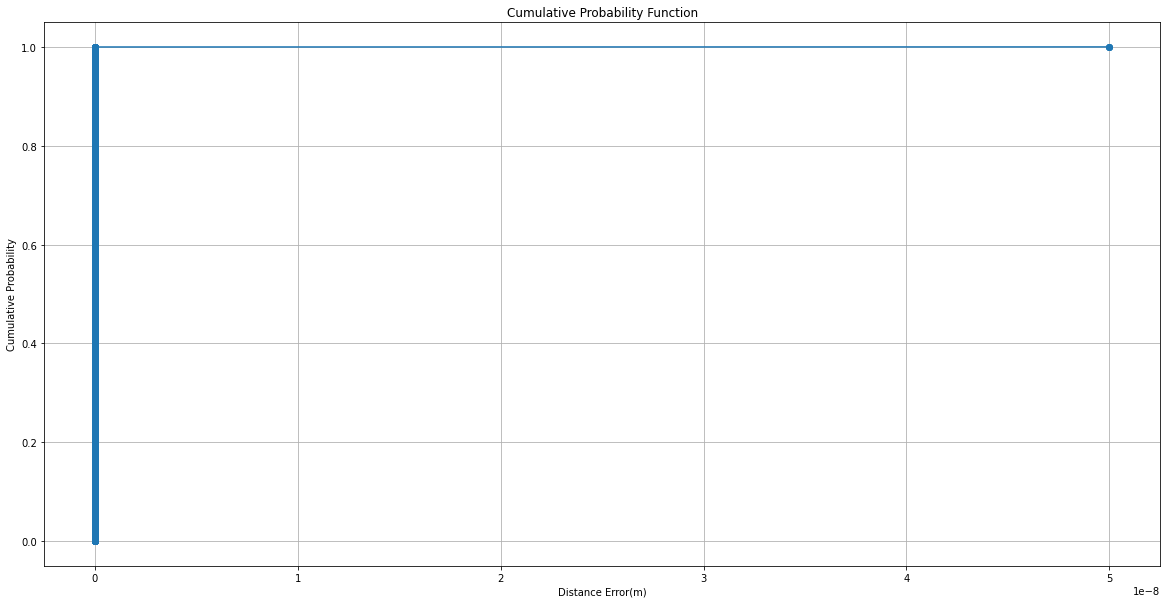

In [31]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(sorted_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()

In [32]:
# Save sorted values and cdf_values into a file
# print(sorted_errors)
# print(cdf_vals)

wknn_sorted_errors = np.array(sorted_errors)
wknn_cdf_vals = np.array(cdf_vals)

np.save('wknn_sorted_errors.npy', wknn_sorted_errors)
np.save('wknn_cdf_vals', wknn_cdf_vals)

### Test of model's performance with non-optimal hyperparameters chosen

- Current set of value that gives optimal result: K = 6, num_segments = 3
- Repeat but with poorly chosen K (no. of clusters) and num_segment (no. of hash values possible) values

In [200]:
print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/datasets


In [201]:
# Get dictionary of RP index and coordinates
# Open HDF5 file and access the dataset
filename = 'dataset_SNR10_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

# Close the HDF5 file
hdf5_file.close()

In [202]:
# Import dataset
features = np.load('augmented_features_10_ue1_v2_ds.npy')
labels = np.load('augmented_labels_10_ue1_v2_ds.npy')

print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

X = features
y = labels

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Shape of features np array: (89628, 193, 16)
Shape of labels np array: (89628,)


In [203]:
from sklearn.model_selection import train_test_split
import numpy as np

# Import dataset
features = np.load('augmented_features_10_ue1_v2_ds.npy')
labels = np.load('augmented_labels_10_ue1_v2_ds.npy')

print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

X = features
y = labels

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Shape of features np array: (89628, 193, 16)
Shape of labels np array: (89628,)


In [204]:
# As data across different samples are taken at different time intervals, makes
# sense to average the value out
# Reduce each feature from shape of (193, 16) --> (1, 16)

# Preprocess X_train and X_test => Reduce dimensions by averaging
reduced_X_train = []
reduced_X_test = []

for feature in X_train:  
    reduced_X_train.append(np.mean(feature, axis = 0))
for feature in X_test:
    reduced_X_test.append(np.mean(feature, axis = 0))
    
X_train = np.array(reduced_X_train)
X_test = np.array(reduced_X_test)

print(X_train.shape)
print(X_test.shape)

(71702, 16)
(17926, 16)


In [149]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [150]:
# Perform clustering using optimal number of clusters
kmeans_model = KMeans(n_clusters = 6).fit(X_train)

# Get the correct cluster for each of the RP
label_arr = kmeans_model.labels_
print(f'No. of unique clusters: {np.unique(label_arr)}')
print(f'No. of fp clustered: {len(label_arr)}')

# Create a database containing key-value of location vector, cluster no. and fingerprint
processed_fp_db = []
for i in range(len(X_train)):
    
    processed_fp = {}
    processed_fp['coords_idx'] = y_train[i]
    processed_fp['cluster_no'] = label_arr[i]
    processed_fp['fp'] = X_train[i]
    processed_fp_db.append(processed_fp)

print(len(processed_fp_db), processed_fp_db[0])

No. of unique clusters: [0 1 2 3 4 5]
No. of fp clustered: 71702
71702 {'coords_idx': 383, 'cluster_no': 3, 'fp': array([0.64390807, 0.26444111, 0.56497193, 0.58222285, 0.66000711,
       0.29986503, 0.52431564, 0.61377072, 0.66395987, 0.35654856,
       0.47202562, 0.64252936, 0.65919535, 0.41383729, 0.42154467,
       0.65629   ])}


In [151]:
alpha_vector = np.random.standard_normal(size = (1,16))

Cluster 0
Max: -0.15802643240061154, Min: -1.349374688939077, Avg: -0.8455646293320269, IQR: 0.2542993366324149, No. of bins: 61
Cluster 1
Max: -0.41510723135486916, Min: -1.490656763322165, Avg: -0.9231029609330204, IQR: 0.22926742018443025, No. of bins: 59
Cluster 2
Max: 0.7793886784027946, Min: -0.5611256167888753, Avg: 0.06160932061602885, IQR: 0.38174681760578, No. of bins: 35
Cluster 3
Max: -0.08552727502920576, Min: -1.6265861828682426, Avg: -0.9112436227832287, IQR: 0.34694361843200805, No. of bins: 55
Cluster 4
Max: -1.183277195755176, Min: -2.245685074011896, Avg: -1.723526256592355, IQR: 0.3019050998987727, No. of bins: 35
Cluster 5
Max: -0.14644146768512778, Min: -1.6933436205417411, Avg: -0.8862884930910049, IQR: 0.4032570175169974, No. of bins: 41


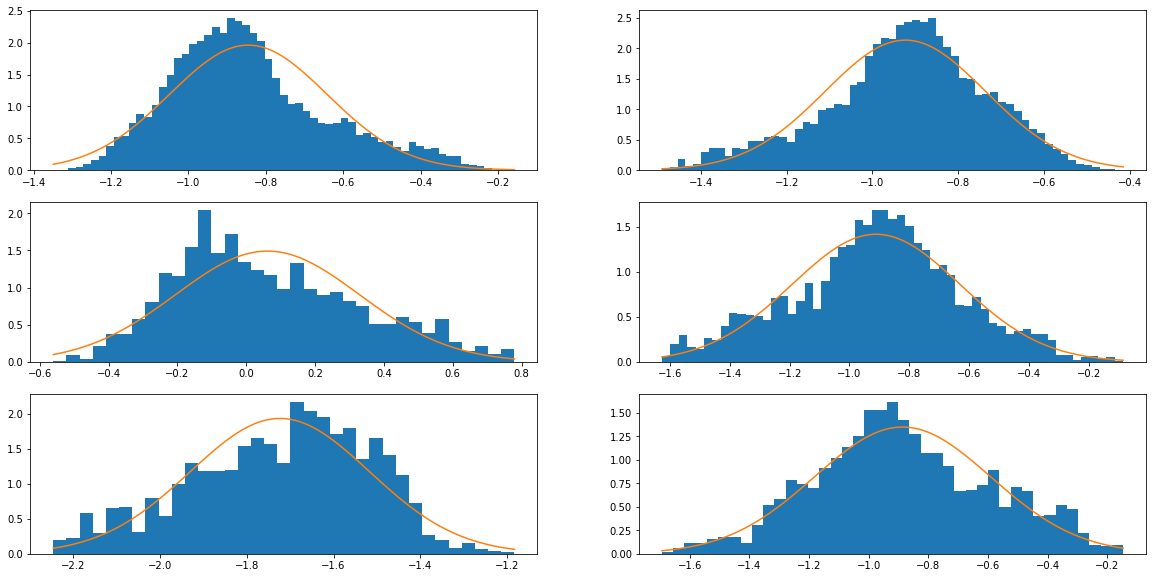

In [152]:
# Get stable distribution - Gaussian normal distribution with mean = 0 and variance = 1,
# with dimension d => (1,16)
import random
from scipy.stats import norm

# Perform dot product alpha_vector . vector v = scalar
# scalar = np.dot(alpha_vector, reduced_dims_features[0])

# For each cluster,
cluster0_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 0]
cluster1_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 1]
cluster2_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 2]
cluster3_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 3]
cluster4_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 4]
cluster5_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 5]

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(3,2)

for i in range(3):
    for j in range(i,i + 2):

        # Determine the elements from each cluster 
        print(f'Cluster {i + j}')
        cluster_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == (i + j)]
        
        # Get distribution of scalar quantities for each poimt
        num_features = len(cluster_rps)
        scalar_res = np.zeros(shape = (num_features, 1), dtype = np.float64)
    
        for k in range(num_features):
            scalar_res[k] = np.dot(alpha_vector, cluster_rps[k]['fp'])
        
        (n, bins, patches) = axs[i][j - i].hist(scalar_res, bins = 'auto', density = True)
#       print(f'Number of bins: {len(n)}, Data point count for each bin: {n}')

        max_val = np.amax(scalar_res)
        min_val = np.amin(scalar_res)
        avg_val = np.mean(scalar_res)
        q75, q25 = np.percentile(scalar_res, [75,25])
        iqr = q75 - q25
    
        print(f'Max: {max_val}, Min: {min_val}, Avg: {avg_val}, IQR: {iqr}, No. of bins: {len(n)}')
        x = np.linspace(min_val, max_val, 100)
        axs[i][j - i].plot(x, norm.pdf(x, np.mean(scalar_res), np.std(scalar_res)))

In [153]:
# Generation of hash function
# Let length r be (cluster max - cluster min) / 100
# Stick to 100 hash values for now to make sure data points are evenly spread out, but not too little
# points per hash value
import math

def get_minmax(cluster_rps):
    
    num_features = len(cluster_rps)
    scalar_res = np.zeros(shape = (num_features, 1), dtype = np.float64)
    
    for k in range(num_features):
        scalar_res[k] = np.dot(alpha_vector, cluster_rps[k]['fp'])
    
    return (np.amax(scalar_res), np.amin(scalar_res))

def get_hash_values(cluster_rps):
    
    max_val, min_val = get_minmax(cluster_rps)
    
    # Declare parameters of hash function
    num_segments = 25
    r = (max_val - min_val) / num_segments
    b = random.uniform(0, r)
    
    # print(r,b)
    
    # Make hash table
    hash_table = {}
    
    # Generate hash values for each of the RP
    for rp in cluster_rps:
        
        hash_value = math.floor((np.dot(alpha_vector, rp['fp']) + b) / r)
        cur_vals = hash_table.get(hash_value, [])
        cur_vals.append(rp['coords_idx'])
        hash_table[hash_value] = cur_vals
        
    return r, b, hash_table

Cluster 0
r: 0.047653930261538614, b: 0.03974047262492535
Cluster 1
r: 0.043021981278691834, b: 0.03651238073459537
Cluster 2
r: 0.0536205718076668, b: 0.029921124899781104
Cluster 3
r: 0.06164235631356148, b: 0.013176066768315668
Cluster 4
r: 0.0424963151302688, b: 0.017122936640304617
Cluster 5
r: 0.06187608611426453, b: 0.03413137477041388


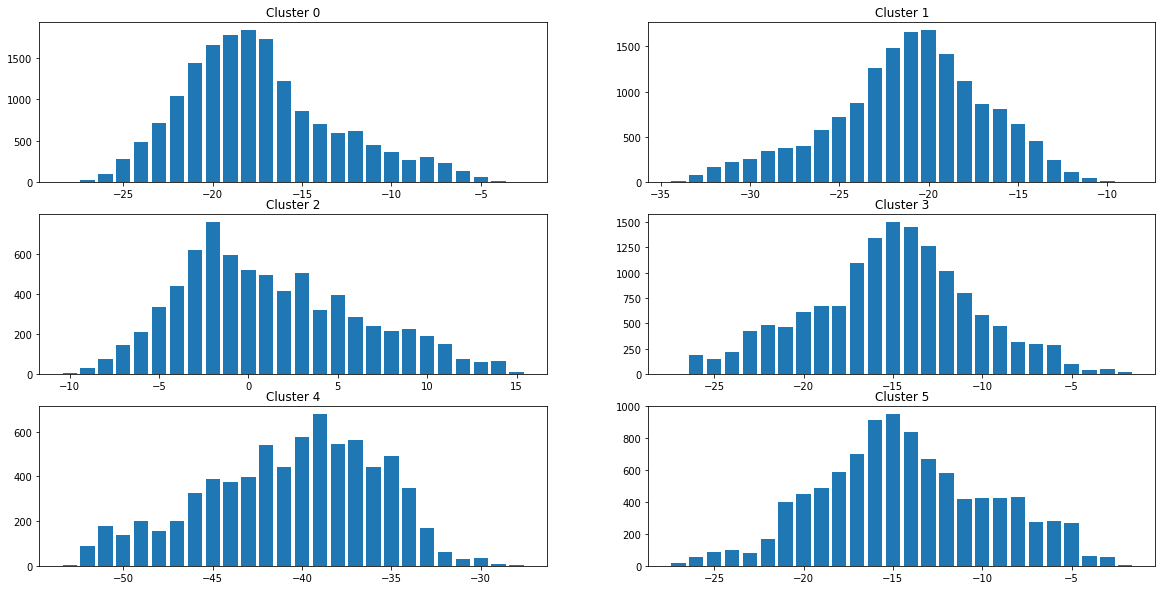

In [154]:
# For each cluster, visualise the spread of hashed values using a histogram
plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(3,2)

for i in range(3):
    for j in range(i,i + 2):

        # Determine the elements from each cluster 
        print(f'Cluster {i + j}')
        cluster_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == (i + j)]
        
        # Get hash values for each cluster
        r, b, hash_vals = get_hash_values(cluster_rps)
        print(f'r: {r}, b: {b}')
        
        keys = []
        num_vals = []
        
        for key, values in hash_vals.items():
            keys.append(key)
            num_vals.append(len(values))
            
        axs[i][j - i].bar(x = keys, height = num_vals)
        axs[i][j - i].title.set_text(f'Cluster {i + j}')

In [155]:
# Get hash values for each cluster 
r0, b0, cluster0_hashvals = get_hash_values(cluster0_rps)
r1, b1, cluster1_hashvals = get_hash_values(cluster1_rps)
r2, b2, cluster2_hashvals = get_hash_values(cluster2_rps)
r3, b3, cluster3_hashvals = get_hash_values(cluster3_rps)
r4, b4, cluster4_hashvals = get_hash_values(cluster4_rps)
r5, b5, cluster5_hashvals = get_hash_values(cluster5_rps)

In [156]:
# Save details of each hash function into a dictionary
clustered_rps = [cluster0_rps, cluster1_rps, cluster2_rps, cluster3_rps, cluster4_rps, cluster5_rps]
clustered_rps = enumerate(clustered_rps)
hash_dict = {}

for index, cluster in clustered_rps:
    r, b, hash_vals = get_hash_values(cluster)
    hash_dict[index] = {'r': r, 'b': b, 'hashs': hash_vals}

In [157]:
# Function to calculate Euclidean distance
def get_ed(actual_rp, candidate_rp):
    return math.dist(actual_rp, candidate_rp)

# Exploit WKNN algorithm to choose first K RPs
# Here, let k = 3, weight = 1 / get_ed(actual_rp, candidate_rp)
# candidate_rps should be given in as a key which is the key in rp_dict which maps back to the
# actual coordinates 
def wknn(actual_rp, candidate_rps, k = 3):
    
    distances = []
    
    # For every candidate point,
    for index in candidate_rps:
        
        # Calculate the distance from each candidate point
        coords = rp_dict[index]
        dist = get_ed(rp_dict[actual_rp], coords)
        
        if dist == 0:
            # Set an arbitrary large enough number
            weight = 1e7
        else:
            weight = 1 / dist
            
        distances.append((index, coords, weight, dist))
        
    # Sort the array based on dist
    sorted_distances = sorted(distances, key = lambda tup: tup[3])
            
    # Exploit WKNN to get positioning
    # Get top candidates
    top_k_candidates = sorted_distances[:k]
    
    # For checking purposes
    # for index, _ , _ in top_k_candidates:
    #    print(rp_dict[index])
    
    # Get predicted positioning using best candidates
    # Get coordinates for all candidate positions
    candidate_pos = []
    weights = []
    
    for _, candidate, weight, _ in top_k_candidates:
        candidate_pos.append(candidate)
        weights.append(weight)
    
    # Take the weighted average of top k candidate positions to predict location
    predicted_position = np.average(candidate_pos, weights = weights, axis = 0)
    
    return predicted_position

In [158]:
# This function takes in a fingerprint from an unknown location and tries to predict
# the location
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import math

def get_closesthash(y, predicted_cluster):
    
    # For each of the hash value in this cluster,
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    actual_coords = rp_dict[y]
    
    min_avgdisterror = math.inf
    min_hashval = None
    
    for hash_val in hash_vals.keys():
        
        # Get all neighbours with that hash value
        neighbours = hash_vals[hash_val]
        err_sum = 0
        
        # Find out the average distance error with neighbouring points with this hash value        
        for neighbour in neighbours:
            
            # Calculate errors
            neighbour_coords = rp_dict[neighbour]
            err = get_ed(actual_coords, neighbour_coords) 
            err_sum += err
            
            # Calculate average
            err_avg = err_sum / len(neighbours)
            
            # Update minimum
            if err_avg < min_avgdisterror:
                min_avgdisterror = err_avg
                min_hashval = hash_val
                
        # Return the cluster with the least error
        return min_hashval
    
# Note: Fingerprint is already in the reduced dimensions form
def get_pred(x, y):
    
    # Step 1: Predict what cluster is this fp from
    predicted_cluster = kmeans_model.predict([x])[0]
    
    # Step 2: Get the hash details for that predicted cluster
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    
    # Step 3: Get the hash value for that unknown fp
    hashed_value = math.floor((np.dot(alpha_vector, x) + b) / r)
 
    # Step 4: Apply wknn algorithm on the the unknown fp
    # if the derived hash value is not present in hashed values,
    if hashed_value not in hash_vals.keys():
        # Find out the average distance error from each of the other hashed
        # value in this cluster
        # Then, use wknn on points with this hash value in this cluster
        closest_hashval = get_closesthash(y, predicted_cluster)
        y_pred = wknn(y, hash_vals[closest_hashval])
        
    else: 
        y_pred = wknn(y, hash_vals[hashed_value])
    
    return y_pred

In [159]:
# Iterate through the y_test dataset and get a prediction for each of the coordinate
y_pred = []

for i in range(len(y_test)):
    
    cur_test_sample = X_test[i]
    cur_test_label = y_test[i]
    pred = get_pred(cur_test_sample, cur_test_label)
    y_pred.append(pred)

In [160]:
def get_disterr(actual, predicted):

    x_error = (actual[0] - predicted[0])**2
    y_error = (actual[1] - predicted[1])**2
    z_error = (actual[2] - predicted[2])**2
    return x_error + y_error + z_error

def get_errcdf(errors):
    # Sort the array
    sorted_data = np.sort(errors)

    # Calculate cumulative probabilities
    n = len(sorted_data)
    cumulative_probs = np.arange(1, n + 1) / n

    return (sorted_data, cumulative_probs)
    
err_sum = 0
dist_errors = []

for i in range(len(y_pred)):
    
    actual_coords = rp_dict[y_test[i]]
    err = get_disterr(actual_coords, y_pred[i])
    err_sum += err
    dist_errors.append(np.sqrt(err))

sorted_errors, cdf_vals = get_errcdf(dist_errors)

print(f'RMSE: {np.sqrt((err_sum/len(y_pred)))}')

RMSE: 0.29399160000781327


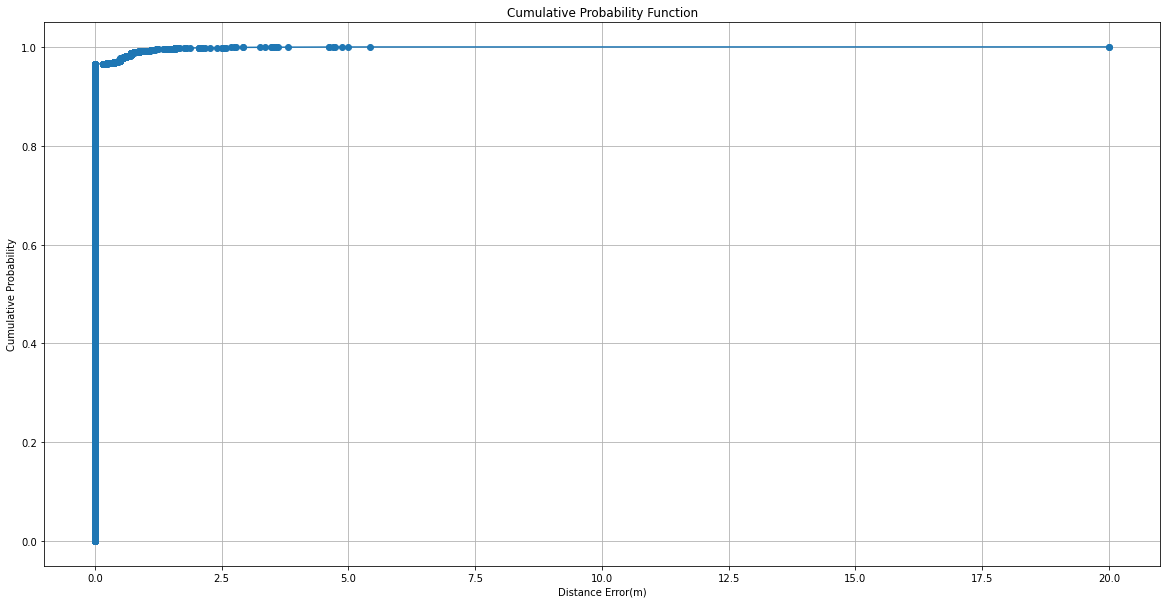

In [161]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(sorted_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()

## <a id='wknn_raw_100samples_miso_snr40'>Trial 3: Raw NTU's MISO SNR40 dataset, 100 samples per RP</a>

In [76]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib
import h5py
from sklearn.model_selection import train_test_split
import numpy as np
import os

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [77]:
# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


In [78]:
print(os.getcwd())
os.chdir('../datasets/ntu_dataset')
print(os.getcwd())

/home/jovyan/committed_git/wknn
/home/jovyan/committed_git/datasets/ntu_dataset


In [79]:
# Read in data from numpy array files
features = np.load('miso_snr40_raw_features.npy')
labels = np.load('miso_snr40_raw_labels.npy')

# Normalise the features data obtained
num_features = features.shape[2]
num_rps = features.shape[0]

normalised_features = np.zeros(features.shape, dtype = np.float32)

for i in range(num_rps):
    
    for j in range(num_features):
        
        cur_feature_arr = features[:,:,j]
        
        min_val = np.amin(cur_feature_arr)
        max_val = np.amax(cur_feature_arr)
        
        constant = False
        if max_val - min_val == 0:
            constant = True
            
        for k in range(len(features[i][:,j])):
            
            if constant:
                normalised_features[i][k][j] = 0
            else:
                normalised_features[i][k][j] = (features[i][k][j] - min_val) / (max_val - min_val)

print(f'Shape of array before normalisation: {features.shape}')
print(f'Shape of array after normalisation: {normalised_features.shape}')

# For labels, have a shape of (1,) where that number represents the class of that coordinate
# Prepare labels for dataset
class_labels = np.array([i for i in range(num_rps)])
count = 0
rp_dict = {}

for label in labels:
    rp_dict[count] = label
    count += 1

Shape of array before normalisation: (277, 100, 14)
Shape of array after normalisation: (277, 100, 14)


In [80]:
# Train validation split the data
from sklearn.model_selection import train_test_split

X = normalised_features
y = class_labels

# random_state = 42 to always ensure same split of dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.125, random_state=42, shuffle = True)

In [81]:
print(normalised_features.shape)
print(labels.shape)
print(class_labels.shape)

(277, 100, 14)
(277, 2)
(277,)


In [83]:
print(os.getcwd())
os.chdir('../../wknn')
print(os.getcwd())

/home/jovyan/committed_git/datasets/ntu_dataset
/home/jovyan/committed_git/wknn


In [84]:
# As data across different samples are taken at different time intervals, makes
# sense to average the value out
# Reduce each feature from shape of (193, 16) --> (1, 16)

# Preprocess X_train and X_test => Reduce dimensions by averaging
reduced_X_train = []
reduced_X_test = []
reduced_X_val = []

for feature in X_train:  
    reduced_X_train.append(np.mean(feature, axis = 0))
for feature in X_test:
    reduced_X_test.append(np.mean(feature, axis = 0))
for feature in X_val:
    reduced_X_val.append(np.mean(feature, axis = 0))
        
X_train = np.array(reduced_X_train, dtype = np.float64)
X_test = np.array(reduced_X_test, dtype = np.float64)
X_val = np.array(reduced_X_val, dtype = np.float64)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(193, 14)
(56, 14)
(28, 14)


In [85]:
# Perform clustering using optimal number of clusters
kmeans_model = KMeans(n_clusters = 6).fit(X_train)

# Get the correct cluster for each of the RP
label_arr = kmeans_model.labels_
print(f'No. of unique clusters: {np.unique(label_arr)}')
print(f'No. of fp clustered: {len(label_arr)}')

# Create a database containing key-value of location vector, cluster no. and fingerprint
processed_fp_db = []
for i in range(len(X_train)):
    
    processed_fp = {}
    processed_fp['coords_idx'] = y_train[i]
    processed_fp['cluster_no'] = label_arr[i]
    processed_fp['fp'] = X_train[i]
    processed_fp_db.append(processed_fp)

print(len(processed_fp_db), processed_fp_db[0])

No. of unique clusters: [0 1 2 3 4 5]
No. of fp clustered: 193
193 {'coords_idx': 109, 'cluster_no': 0, 'fp': array([0.93025118, 0.45756304, 0.91773355, 0.55789477, 0.90417558,
       0.528005  , 0.89170265, 0.52377677, 0.93904877, 0.        ,
       0.91267669, 0.19360419, 0.82714391, 0.99268991])}


In [86]:
# Generation of hash function
# Let length r be (cluster max - cluster min) / 100
# Stick to 100 hash values for now to make sure data points are evenly spread out, but not too little
# points per hash value
import math
import random

def get_minmax(cluster_rps):
    
    num_features = len(cluster_rps)
    scalar_res = np.zeros(shape = (num_features, 1), dtype = np.float64)
    
    for k in range(num_features):
        scalar_res[k] = np.dot(alpha_vector, cluster_rps[k]['fp'])
    
    return (np.amax(scalar_res), np.amin(scalar_res))

def get_hash_values(cluster_rps):
    
    max_val, min_val = get_minmax(cluster_rps)
    
    # Declare parameters of hash function
    num_segments = 3
    r = (max_val - min_val) / num_segments
    b = random.uniform(0, r)
    
    # print(r,b)
    
    # Make hash table
    hash_table = {}
    
    # Generate hash values for each of the RP
    for rp in cluster_rps:
        
        hash_value = math.floor((np.dot(alpha_vector, rp['fp']) + b) / r)
        cur_vals = hash_table.get(hash_value, [])
        cur_vals.append(rp['coords_idx'])
        hash_table[hash_value] = cur_vals
        
    return r, b, hash_table

In [87]:
alpha_vector = np.random.standard_normal(size = (1,14))

In [88]:
# Get hash values for each cluster 
# For each cluster,
cluster0_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 0]
cluster1_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 1]
cluster2_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 2]
cluster3_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 3]
cluster4_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 4]
cluster5_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 5]

r0, b0, cluster0_hashvals = get_hash_values(cluster0_rps)
r1, b1, cluster1_hashvals = get_hash_values(cluster1_rps)
r2, b2, cluster2_hashvals = get_hash_values(cluster2_rps)
r3, b3, cluster3_hashvals = get_hash_values(cluster3_rps)
r4, b4, cluster4_hashvals = get_hash_values(cluster4_rps)
r5, b5, cluster5_hashvals = get_hash_values(cluster5_rps)

In [89]:
# Save details of each hash function into a dictionary
clustered_rps = [cluster0_rps, cluster1_rps, cluster2_rps, cluster3_rps, cluster4_rps, cluster5_rps]
clustered_rps = enumerate(clustered_rps)
hash_dict = {}

for index, cluster in clustered_rps:
    r, b, hash_vals = get_hash_values(cluster)
    hash_dict[index] = {'r': r, 'b': b, 'hashs': hash_vals}

In [90]:
# Function to calculate Euclidean distance
def get_ed(actual_rp, candidate_rp):
    return math.dist(actual_rp, candidate_rp)

# Exploit WKNN algorithm to choose first K RPs
# Here, let k = 3, weight = 1 / get_ed(actual_rp, candidate_rp)
# candidate_rps should be given in as a key which is the key in rp_dict which maps back to the
# actual coordinates 
def wknn(actual_rp, candidate_rps, k = 3):
    
    distances = []
    
    # For every candidate point,
    for index in candidate_rps:
        
        # Calculate the distance from each candidate point
        coords = rp_dict[index]
        dist = get_ed(rp_dict[actual_rp], coords)
        
        if dist == 0:
            # Set an arbitrary large enough number
            weight = 1e7
        else:
            weight = 1 / dist
            
        distances.append((index, coords, weight, dist))
        
    # Sort the array based on dist
    sorted_distances = sorted(distances, key = lambda tup: tup[3])
            
    # Exploit WKNN to get positioning
    # Get top candidates
    top_k_candidates = sorted_distances[:k]
    
    # For checking purposes
    # for index, _ , _ in top_k_candidates:
    #    print(rp_dict[index])
    
    # Get predicted positioning using best candidates
    # Get coordinates for all candidate positions
    candidate_pos = []
    weights = []
    
    for _, candidate, weight, _ in top_k_candidates:
        candidate_pos.append(candidate)
        weights.append(weight)
    
    # Take the weighted average of top k candidate positions to predict location
    predicted_position = np.average(candidate_pos, weights = weights, axis = 0)
    
    return predicted_position

In [91]:
# This function takes in a fingerprint from an unknown location and tries to predict
# the location
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import math

def get_closesthash(y, predicted_cluster):
    
    # For each of the hash value in this cluster,
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    actual_coords = rp_dict[y]
    
    min_avgdisterror = math.inf
    min_hashval = None
    
    for hash_val in hash_vals.keys():
        
        # Get all neighbours with that hash value
        neighbours = hash_vals[hash_val]
        err_sum = 0
        
        # Find out the average distance error with neighbouring points with this hash value        
        for neighbour in neighbours:
            
            # Calculate errors
            neighbour_coords = rp_dict[neighbour]
            err = get_ed(actual_coords, neighbour_coords) 
            err_sum += err
            
            # Calculate average
            err_avg = err_sum / len(neighbours)
            
            # Update minimum
            if err_avg < min_avgdisterror:
                min_avgdisterror = err_avg
                min_hashval = hash_val
                
        # Return the cluster with the least error
        return min_hashval
    
# Note: Fingerprint is already in the reduced dimensions form
def get_pred(x, y):
    
    # Step 1: Predict what cluster is this fp from
    predicted_cluster = kmeans_model.predict([x])[0]
    
    # Step 2: Get the hash details for that predicted cluster
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    
    # Step 3: Get the hash value for that unknown fp
    hashed_value = math.floor((np.dot(alpha_vector, x) + b) / r)
 
    # Step 4: Apply wknn algorithm on the the unknown fp
    # if the derived hash value is not present in hashed values,
    if hashed_value not in hash_vals.keys():
        # Find out the average distance error from each of the other hashed
        # value in this cluster
        # Then, use wknn on points with this hash value in this cluster
        closest_hashval = get_closesthash(y, predicted_cluster)
        y_pred = wknn(y, hash_vals[closest_hashval])
        
    else: 
        y_pred = wknn(y, hash_vals[hashed_value])
    
    return y_pred

In [93]:
# Iterate through the y_test dataset and get a prediction for each of the coordinate
y_pred = []

for i in range(len(y_test)):
    
    cur_test_sample = X_test[i]
    cur_test_label = y_test[i]
    pred = get_pred(cur_test_sample, cur_test_label)
    y_pred.append(pred)

In [94]:
def get_disterr(actual, predicted):

    x_error = (actual[0] - predicted[0])**2
    y_error = (actual[1] - predicted[1])**2

    return x_error + y_error

def get_errcdf(errors):
    # Sort the array
    sorted_data = np.sort(errors)

    # Calculate cumulative probabilities
    n = len(sorted_data)
    cumulative_probs = np.arange(1, n + 1) / n

    return (sorted_data, cumulative_probs)
    
err_sum = 0
dist_errors = []

for i in range(len(y_pred)):
    
    actual_coords = rp_dict[y_test[i]]
    err = get_disterr(actual_coords, y_pred[i])
    err_sum += err
    dist_errors.append(np.sqrt(err))

sorted_errors, cdf_vals = get_errcdf(dist_errors)

print(f'RMSE: {np.sqrt((err_sum/len(y_pred)))}')

RMSE: 92.34030302684496


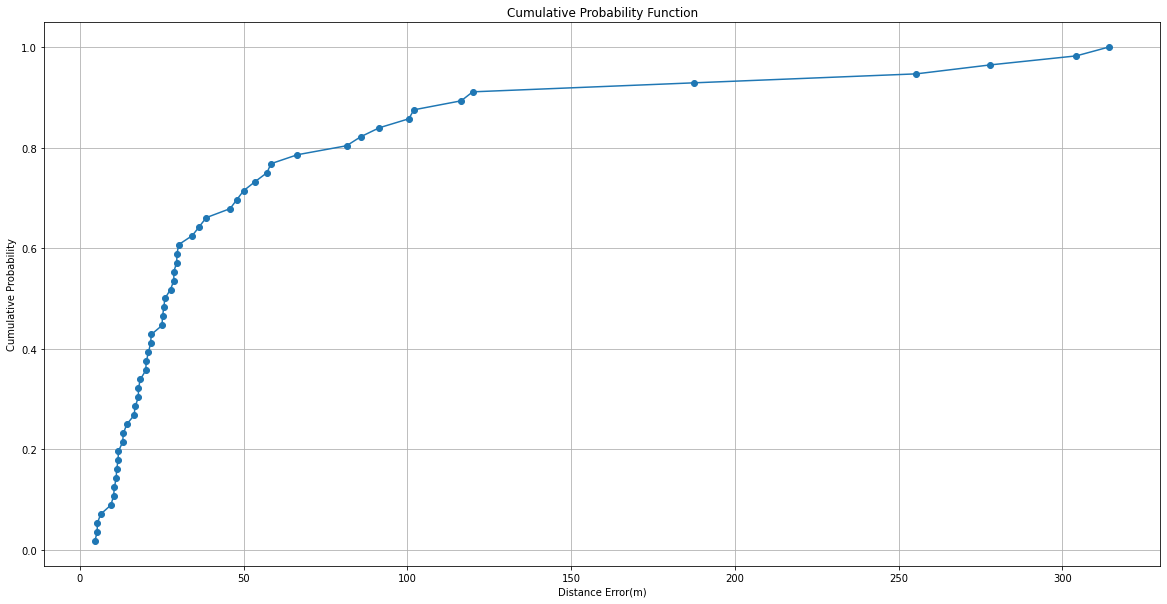

In [95]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(sorted_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()

## <a id='wknn_raw_1sample_miso_snr40'>Trial 4: Raw NTU's MISO SNR40 dataset, 1 sample per RP</a>

In [2]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib
import h5py
from sklearn.model_selection import train_test_split
import numpy as np
import os

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [3]:
print(os.getcwd())
os.chdir('../datasets/ntu_dataset')
print(os.getcwd())

/home/jovyan/committed_git/wknn
/home/jovyan/committed_git/datasets/ntu_dataset


In [5]:
# Read in data from numpy array files
features = np.load('miso_snr40_raw_features.npy')
labels = np.load('miso_snr40_raw_labels.npy')

# Normalise the features data obtained
num_rps = features.shape[0]

features = features[:,0,:]
print("First samples of each RP: ", features.shape)

# For labels, have a shape of (1,) where that number represents the class of that coordinate
# Prepare labels for dataset
class_labels = np.array([i for i in range(num_rps)])
count = 0
rp_dict = {}

for label in labels:
    rp_dict[count] = label
    count += 1

First samples of each RP:  (277, 14)


In [6]:
# Train validation split the data
from sklearn.model_selection import train_test_split

X = features
y = class_labels

# random_state = 42 to always ensure same split of dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.125, random_state=42, shuffle = True)

In [8]:
print(features.shape)
print(labels.shape)
print(class_labels.shape)

(277, 14)
(277, 2)
(277,)


In [9]:
print(os.getcwd())
os.chdir('../../wknn')
print(os.getcwd())

/home/jovyan/committed_git/datasets/ntu_dataset
/home/jovyan/committed_git/wknn


In [10]:
# Perform clustering using optimal number of clusters
kmeans_model = KMeans(n_clusters = 6).fit(X_train)

# Get the correct cluster for each of the RP
label_arr = kmeans_model.labels_
print(f'No. of unique clusters: {np.unique(label_arr)}')
print(f'No. of fp clustered: {len(label_arr)}')

# Create a database containing key-value of location vector, cluster no. and fingerprint
processed_fp_db = []
for i in range(len(X_train)):
    
    processed_fp = {}
    processed_fp['coords_idx'] = y_train[i]
    processed_fp['cluster_no'] = label_arr[i]
    processed_fp['fp'] = X_train[i]
    processed_fp_db.append(processed_fp)

print(len(processed_fp_db), processed_fp_db[0])

No. of unique clusters: [0 1 2 3 4 5]
No. of fp clustered: 193
193 {'coords_idx': 109, 'cluster_no': 0, 'fp': array([-3.42659772e+01, -2.12086243e-07, -3.09198921e+01, -4.39969941e-07,
       -4.90785871e+01,  1.38716400e-06, -4.93802471e+01,  1.98824513e-06,
       -3.40431484e+01,  0.00000000e+00, -4.03280191e+01,  1.21244604e-06,
       -5.70963372e+01,  6.68082431e-06])}


In [11]:
# Generation of hash function
# Let length r be (cluster max - cluster min) / 100
# Stick to 100 hash values for now to make sure data points are evenly spread out, but not too little
# points per hash value
import math
import random

def get_minmax(cluster_rps):
    
    num_features = len(cluster_rps)
    scalar_res = np.zeros(shape = (num_features, 1), dtype = np.float64)
    
    for k in range(num_features):
        scalar_res[k] = np.dot(alpha_vector, cluster_rps[k]['fp'])
    
    return (np.amax(scalar_res), np.amin(scalar_res))

def get_hash_values(cluster_rps):
    
    max_val, min_val = get_minmax(cluster_rps)
    
    # Declare parameters of hash function
    num_segments = 3
    r = (max_val - min_val) / num_segments
    b = random.uniform(0, r)
    
    # print(r,b)
    
    # Make hash table
    hash_table = {}
    
    # Generate hash values for each of the RP
    for rp in cluster_rps:
        
        hash_value = math.floor((np.dot(alpha_vector, rp['fp']) + b) / r)
        cur_vals = hash_table.get(hash_value, [])
        cur_vals.append(rp['coords_idx'])
        hash_table[hash_value] = cur_vals
        
    return r, b, hash_table

In [12]:
alpha_vector = np.random.standard_normal(size = (1,14))

In [13]:
# Get hash values for each cluster 
# For each cluster,
cluster0_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 0]
cluster1_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 1]
cluster2_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 2]
cluster3_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 3]
cluster4_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 4]
cluster5_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 5]

r0, b0, cluster0_hashvals = get_hash_values(cluster0_rps)
r1, b1, cluster1_hashvals = get_hash_values(cluster1_rps)
r2, b2, cluster2_hashvals = get_hash_values(cluster2_rps)
r3, b3, cluster3_hashvals = get_hash_values(cluster3_rps)
r4, b4, cluster4_hashvals = get_hash_values(cluster4_rps)
r5, b5, cluster5_hashvals = get_hash_values(cluster5_rps)

In [14]:
# Save details of each hash function into a dictionary
clustered_rps = [cluster0_rps, cluster1_rps, cluster2_rps, cluster3_rps, cluster4_rps, cluster5_rps]
clustered_rps = enumerate(clustered_rps)
hash_dict = {}

for index, cluster in clustered_rps:
    r, b, hash_vals = get_hash_values(cluster)
    hash_dict[index] = {'r': r, 'b': b, 'hashs': hash_vals}

In [15]:
# Function to calculate Euclidean distance
def get_ed(actual_rp, candidate_rp):
    return math.dist(actual_rp, candidate_rp)

# Exploit WKNN algorithm to choose first K RPs
# Here, let k = 3, weight = 1 / get_ed(actual_rp, candidate_rp)
# candidate_rps should be given in as a key which is the key in rp_dict which maps back to the
# actual coordinates 
def wknn(actual_rp, candidate_rps, k = 3):
    
    distances = []
    
    # For every candidate point,
    for index in candidate_rps:
        
        # Calculate the distance from each candidate point
        coords = rp_dict[index]
        dist = get_ed(rp_dict[actual_rp], coords)
        
        if dist == 0:
            # Set an arbitrary large enough number
            weight = 1e7
        else:
            weight = 1 / dist
            
        distances.append((index, coords, weight, dist))
        
    # Sort the array based on dist
    sorted_distances = sorted(distances, key = lambda tup: tup[3])
            
    # Exploit WKNN to get positioning
    # Get top candidates
    top_k_candidates = sorted_distances[:k]
    
    # For checking purposes
    # for index, _ , _ in top_k_candidates:
    #    print(rp_dict[index])
    
    # Get predicted positioning using best candidates
    # Get coordinates for all candidate positions
    candidate_pos = []
    weights = []
    
    for _, candidate, weight, _ in top_k_candidates:
        candidate_pos.append(candidate)
        weights.append(weight)
    
    # Take the weighted average of top k candidate positions to predict location
    predicted_position = np.average(candidate_pos, weights = weights, axis = 0)
    
    return predicted_position

In [16]:
# This function takes in a fingerprint from an unknown location and tries to predict
# the location
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import math

def get_closesthash(y, predicted_cluster):
    
    # For each of the hash value in this cluster,
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    actual_coords = rp_dict[y]
    
    min_avgdisterror = math.inf
    min_hashval = None
    
    for hash_val in hash_vals.keys():
        
        # Get all neighbours with that hash value
        neighbours = hash_vals[hash_val]
        err_sum = 0
        
        # Find out the average distance error with neighbouring points with this hash value        
        for neighbour in neighbours:
            
            # Calculate errors
            neighbour_coords = rp_dict[neighbour]
            err = get_ed(actual_coords, neighbour_coords) 
            err_sum += err
            
            # Calculate average
            err_avg = err_sum / len(neighbours)
            
            # Update minimum
            if err_avg < min_avgdisterror:
                min_avgdisterror = err_avg
                min_hashval = hash_val
                
        # Return the cluster with the least error
        return min_hashval
    
# Note: Fingerprint is already in the reduced dimensions form
def get_pred(x, y):
    
    # Step 1: Predict what cluster is this fp from
    predicted_cluster = kmeans_model.predict([x])[0]
    
    # Step 2: Get the hash details for that predicted cluster
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    
    # Step 3: Get the hash value for that unknown fp
    hashed_value = math.floor((np.dot(alpha_vector, x) + b) / r)
 
    # Step 4: Apply wknn algorithm on the the unknown fp
    # if the derived hash value is not present in hashed values,
    if hashed_value not in hash_vals.keys():
        # Find out the average distance error from each of the other hashed
        # value in this cluster
        # Then, use wknn on points with this hash value in this cluster
        closest_hashval = get_closesthash(y, predicted_cluster)
        y_pred = wknn(y, hash_vals[closest_hashval])
        
    else: 
        y_pred = wknn(y, hash_vals[hashed_value])
    
    return y_pred

In [17]:
# Iterate through the y_test dataset and get a prediction for each of the coordinate
y_pred = []

for i in range(len(y_test)):
    
    cur_test_sample = X_test[i]
    cur_test_label = y_test[i]
    pred = get_pred(cur_test_sample, cur_test_label)
    y_pred.append(pred)

In [18]:
def get_disterr(actual, predicted):

    x_error = (actual[0] - predicted[0])**2
    y_error = (actual[1] - predicted[1])**2

    return x_error + y_error

def get_errcdf(errors):
    # Sort the array
    sorted_data = np.sort(errors)

    # Calculate cumulative probabilities
    n = len(sorted_data)
    cumulative_probs = np.arange(1, n + 1) / n

    return (sorted_data, cumulative_probs)
    
err_sum = 0
dist_errors = []

for i in range(len(y_pred)):
    
    actual_coords = rp_dict[y_test[i]]
    err = get_disterr(actual_coords, y_pred[i])
    err_sum += err
    dist_errors.append(np.sqrt(err))

sorted_errors, cdf_vals = get_errcdf(dist_errors)

print(f'RMSE: {np.sqrt((err_sum/len(y_pred)))}')

RMSE: 85.5644935546854


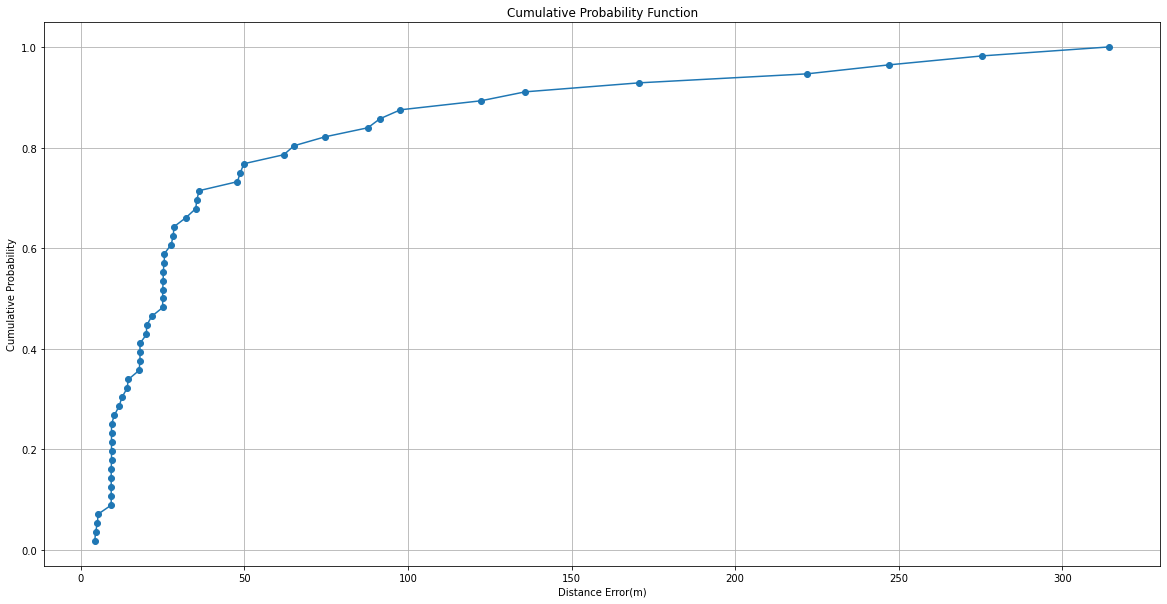

In [19]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(sorted_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()

## <a id='wknn_augmented_miso_snr40'>Trial 5: Augmented NTU's MISO SNR40 dataset</a>

In [23]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import h5py
from sklearn.model_selection import train_test_split
import numpy as np
import os

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [24]:
# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

2.9.1


In [25]:
print(os.getcwd())
os.chdir('../datasets/ntu_dataset')
print(os.getcwd())

/home/jovyan/committed_git/wknn
/home/jovyan/committed_git/datasets/ntu_dataset


In [26]:
# Read in data from numpy array files
features = np.load('miso_snr40_augmented_features.npy')
labels = np.load('miso_snr40_augmented_labels.npy')

# Normalise the features data obtained
num_features = features.shape[2]
num_rps = labels.shape[0]

normalised_features = np.zeros(features.shape, dtype = np.float32)

for i in range(num_rps):
    
    for j in range(num_features):
        
        cur_feature_arr = features[:,:,j]
        
        min_val = np.amin(cur_feature_arr)
        max_val = np.amax(cur_feature_arr)
        
        constant = False
        if max_val - min_val == 0:
            constant = True
            
        for k in range(len(features[i][:,j])):
            
            if constant:
                normalised_features[i][k][j] = 0
            else:
                normalised_features[i][k][j] = (features[i][k][j] - min_val) / (max_val - min_val)

print(f'Shape of array before normalisation: {features.shape}')
print(f'Shape of array after normalisation: {normalised_features.shape}')

# For labels, have a shape of (1,) where that number represents the class of that coordinate
# Prepare labels for dataset
count = 0
rp_dict = {}

for label in labels:
    rp_dict[count] = label
    count += 1
    
class_labels = np.array([i for i in range(num_rps)])
class_labels = np.repeat(class_labels, 10, axis = 0)

Shape of array before normalisation: (6770, 100, 14)
Shape of array after normalisation: (6770, 100, 14)


In [27]:
# Train validation split the data
from sklearn.model_selection import train_test_split

X = normalised_features
y = class_labels

# random_state = 42 to always ensure same split of dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.125, random_state=42, shuffle = True)

In [28]:
print(normalised_features.shape)
print(labels.shape)
print(class_labels.shape)

(6770, 100, 14)
(677, 2)
(6770,)


In [29]:
# Train validation split the data
from sklearn.model_selection import train_test_split

X = normalised_features
y = class_labels

# random_state = 42 to always ensure same split of dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.125, random_state=42, shuffle = True)

In [30]:
print(os.getcwd())
os.chdir('../../wknn')
print(os.getcwd())

/home/jovyan/committed_git/datasets/ntu_dataset
/home/jovyan/committed_git/wknn


In [31]:
# As data across different samples are taken at different time intervals, makes
# sense to average the value out
# Reduce each feature from shape of (193, 16) --> (1, 16)

# Preprocess X_train and X_test => Reduce dimensions by averaging
reduced_X_train = []
reduced_X_test = []
reduced_X_val = []

for feature in X_train:  
    reduced_X_train.append(np.mean(feature, axis = 0))
for feature in X_test:
    reduced_X_test.append(np.mean(feature, axis = 0))
for feature in X_val:
    reduced_X_val.append(np.mean(feature, axis = 0))
        
X_train = np.array(reduced_X_train, dtype = np.float64)
X_test = np.array(reduced_X_test, dtype = np.float64)
X_val = np.array(reduced_X_val, dtype = np.float64)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(4739, 14)
(1354, 14)
(677, 14)


In [32]:
# Perform clustering using optimal number of clusters
kmeans_model = KMeans(n_clusters = 6).fit(X_train)

# Get the correct cluster for each of the RP
label_arr = kmeans_model.labels_
print(f'No. of unique clusters: {np.unique(label_arr)}')
print(f'No. of fp clustered: {len(label_arr)}')

# Create a database containing key-value of location vector, cluster no. and fingerprint
processed_fp_db = []
for i in range(len(X_train)):
    
    processed_fp = {}
    processed_fp['coords_idx'] = y_train[i]
    processed_fp['cluster_no'] = label_arr[i]
    processed_fp['fp'] = X_train[i]
    processed_fp_db.append(processed_fp)

print(len(processed_fp_db), processed_fp_db[0])

No. of unique clusters: [0 1 2 3 4 5]
No. of fp clustered: 4739
4739 {'coords_idx': 501, 'cluster_no': 0, 'fp': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}


In [39]:
# Generation of hash function
# Let length r be (cluster max - cluster min) / 100
# Stick to 100 hash values for now to make sure data points are evenly spread out, but not too little
# points per hash value
import math
import random

def get_minmax(cluster_rps):
    
    num_features = len(cluster_rps)
    scalar_res = np.zeros(shape = (num_features, 1), dtype = np.float64)
    
    for k in range(num_features):
        scalar_res[k] = np.dot(alpha_vector, cluster_rps[k]['fp'])
    
    return (np.amax(scalar_res), np.amin(scalar_res))

def get_hash_values(cluster_rps):
    
    max_val, min_val = get_minmax(cluster_rps)
    
    # Declare parameters of hash function
    num_segments = 3
    r = (max_val - min_val) / num_segments
    b = random.uniform(0, r)
    
    # print(r,b)
    
    # Make hash table
    hash_table = {}
    
    # Generate hash values for each of the RP
    for rp in cluster_rps:
        
        if r == 0:
            hash_value = 0.
        else:
            hash_value = math.floor((np.dot(alpha_vector, rp['fp']) + b) / r)
        cur_vals = hash_table.get(hash_value, [])
        cur_vals.append(rp['coords_idx'])
        hash_table[hash_value] = cur_vals
        
    return r, b, hash_table

In [40]:
alpha_vector = np.random.standard_normal(size = (1,14))

In [41]:
# Get hash values for each cluster 
# For each cluster,
cluster0_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 0]
cluster1_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 1]
cluster2_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 2]
cluster3_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 3]
cluster4_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 4]
cluster5_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 5]

r0, b0, cluster0_hashvals = get_hash_values(cluster0_rps)
r1, b1, cluster1_hashvals = get_hash_values(cluster1_rps)
r2, b2, cluster2_hashvals = get_hash_values(cluster2_rps)
r3, b3, cluster3_hashvals = get_hash_values(cluster3_rps)
r4, b4, cluster4_hashvals = get_hash_values(cluster4_rps)
r5, b5, cluster5_hashvals = get_hash_values(cluster5_rps)

In [42]:
# Save details of each hash function into a dictionary
clustered_rps = [cluster0_rps, cluster1_rps, cluster2_rps, cluster3_rps, cluster4_rps, cluster5_rps]
clustered_rps = enumerate(clustered_rps)
hash_dict = {}

for index, cluster in clustered_rps:
    r, b, hash_vals = get_hash_values(cluster)
    hash_dict[index] = {'r': r, 'b': b, 'hashs': hash_vals}

In [43]:
# Function to calculate Euclidean distance
def get_ed(actual_rp, candidate_rp):
    return math.dist(actual_rp, candidate_rp)

# Exploit WKNN algorithm to choose first K RPs
# Here, let k = 3, weight = 1 / get_ed(actual_rp, candidate_rp)
# candidate_rps should be given in as a key which is the key in rp_dict which maps back to the
# actual coordinates 
def wknn(actual_rp, candidate_rps, k = 3):
    
    distances = []
    
    # For every candidate point,
    for index in candidate_rps:
        
        # Calculate the distance from each candidate point
        coords = rp_dict[index]
        dist = get_ed(rp_dict[actual_rp], coords)
        
        if dist == 0:
            # Set an arbitrary large enough number
            weight = 1e7
        else:
            weight = 1 / dist
            
        distances.append((index, coords, weight, dist))
        
    # Sort the array based on dist
    sorted_distances = sorted(distances, key = lambda tup: tup[3])
            
    # Exploit WKNN to get positioning
    # Get top candidates
    top_k_candidates = sorted_distances[:k]
    
    # For checking purposes
    # for index, _ , _ in top_k_candidates:
    #    print(rp_dict[index])
    
    # Get predicted positioning using best candidates
    # Get coordinates for all candidate positions
    candidate_pos = []
    weights = []
    
    for _, candidate, weight, _ in top_k_candidates:
        candidate_pos.append(candidate)
        weights.append(weight)
    
    # Take the weighted average of top k candidate positions to predict location
    predicted_position = np.average(candidate_pos, weights = weights, axis = 0)
    
    return predicted_position

In [46]:
# This function takes in a fingerprint from an unknown location and tries to predict
# the location
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import math

def get_closesthash(y, predicted_cluster):
    
    # For each of the hash value in this cluster,
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    actual_coords = rp_dict[y]
    
    min_avgdisterror = math.inf
    min_hashval = None
    
    for hash_val in hash_vals.keys():
        
        # Get all neighbours with that hash value
        neighbours = hash_vals[hash_val]
        err_sum = 0
        
        # Find out the average distance error with neighbouring points with this hash value        
        for neighbour in neighbours:
            
            # Calculate errors
            neighbour_coords = rp_dict[neighbour]
            err = get_ed(actual_coords, neighbour_coords) 
            err_sum += err
            
            # Calculate average
            err_avg = err_sum / len(neighbours)
            
            # Update minimum
            if err_avg < min_avgdisterror:
                min_avgdisterror = err_avg
                min_hashval = hash_val
                
        # Return the cluster with the least error
        return min_hashval
    
# Note: Fingerprint is already in the reduced dimensions form
def get_pred(x, y):
    
    # Step 1: Predict what cluster is this fp from
    predicted_cluster = kmeans_model.predict([x])[0]
    
    # Step 2: Get the hash details for that predicted cluster
    r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']
    
    # Step 3: Get the hash value for that unknown fp
    if r == 0:
        hashed_value = 0.
    else:
        hashed_value = math.floor((np.dot(alpha_vector, x) + b) / r)
 
    # Step 4: Apply wknn algorithm on the the unknown fp
    # if the derived hash value is not present in hashed values,
    if hashed_value not in hash_vals.keys():
        # Find out the average distance error from each of the other hashed
        # value in this cluster
        # Then, use wknn on points with this hash value in this cluster
        closest_hashval = get_closesthash(y, predicted_cluster)
        y_pred = wknn(y, hash_vals[closest_hashval])
        
    else: 
        y_pred = wknn(y, hash_vals[hashed_value])
    
    return y_pred

In [47]:
# Iterate through the y_test dataset and get a prediction for each of the coordinate
y_pred = []

for i in range(len(y_test)):
    
    cur_test_sample = X_test[i]
    cur_test_label = y_test[i]
    pred = get_pred(cur_test_sample, cur_test_label)
    y_pred.append(pred)

In [52]:
def get_disterr(actual, predicted):

    x_error = (actual[0] - predicted[0])**2
    y_error = (actual[1] - predicted[1])**2

    return x_error + y_error

def get_errcdf(errors):
    # Sort the array
    sorted_data = np.sort(errors)

    # Calculate cumulative probabilities
    n = len(sorted_data)
    cumulative_probs = np.arange(1, n + 1) / n

    return (sorted_data, cumulative_probs)
    
err_sum = 0
dist_errors = []

for i in range(len(y_pred)):
    
    actual_coords = rp_dict[y_test[i]]
    err = get_disterr(actual_coords, y_pred[i])
    err_sum += err
    dist_errors.append(np.sqrt(err))

sorted_errors, cdf_vals = get_errcdf(dist_errors)

print(f'RMSE: {np.sqrt((err_sum/len(y_pred)))}')

RMSE: 3.038405157791285e-09


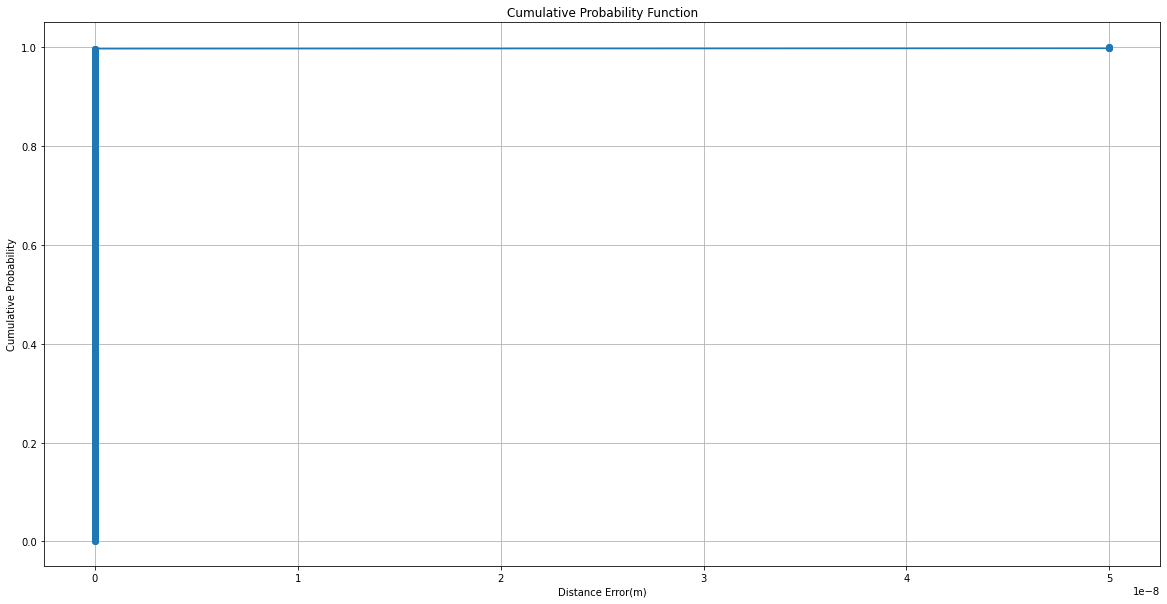

In [53]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(sorted_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()